In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torch.optim as optim
import time
import seaborn as sns
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

In [18]:
# Define transforms without augmentation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 32

# Load the dataset with transforms without augmentation
dataset = datasets.ImageFolder(root='./cnn_dataset/', transform=transform)

# Dataset split into training, validation, and testing set for both versions
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split datasets for both versions
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Dataloaders for both versions
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [3]:
# Check image channel if 1, grayscale image if 3, RGB image
for image,label in trainloader:
    print(image.shape[1])
    break

3


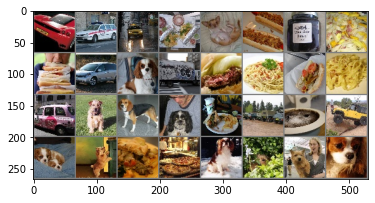

vehicles vehicles vehicles food  dogs  food  food  food  food  vehicles dogs  vehicles food  food  food  food  vehicles dogs  dogs  dogs  food  vehicles food  vehicles dogs  dogs  food  food  dogs  dogs  dogs  dogs 


In [4]:
classes = dataset.classes
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
class VGG13(nn.Module):
    def __init__(self, dropoutAdd=False):
        super(VGG13, self).__init__()
        self.dropoutAdd = dropoutAdd

        # Convolutional layers
        self.conv1 = nn.Sequential(
            # Input: 3 channels, Output: 64 channels
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # Fully-connected layers
        self.fc6 = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5) if self.dropoutAdd else nn.Identity(),
        )
        self.fc7 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5) if self.dropoutAdd else nn.Identity(),
        )

        self.fc8 = nn.Linear(4096, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)
        return x

In [6]:
# Torchinfo Summary of base model
torchinfoSummary = torchinfo.summary(VGG13(dropoutAdd=False), input_data=torch.randn(
    batch_size, 3, 64, 64))  # batch_size=64, channels=3, height=64, width=64
print(torchinfoSummary)

Layer (type:depth-idx)                   Output Shape              Param #
VGG13                                    [32, 3]                   --
├─Sequential: 1-1                        [32, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 64, 64, 64]          1,792
│    └─ReLU: 2-2                         [32, 64, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 64, 64, 64]          36,928
│    └─ReLU: 2-4                         [32, 64, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 64, 32, 32]          --
├─Sequential: 1-2                        [32, 128, 16, 16]         --
│    └─Conv2d: 2-6                       [32, 128, 32, 32]         73,856
│    └─ReLU: 2-7                         [32, 128, 32, 32]         --
│    └─Conv2d: 2-8                       [32, 128, 32, 32]         147,584
│    └─ReLU: 2-9                         [32, 128, 32, 32]         --
│    └─MaxPool2d: 2-10                   [32, 128, 16, 16]         --

In [7]:
def modelTraining(model, criterion, optimizer, earlyStopping=False, imageAug=False):
    
    train_loader = trainloader_augmented if imageAug else trainloader
    val_loader = valloader_augmented if imageAug else valloader
    test_loader = testloader_augmented if imageAug else testloader
        
    import time

    startTime = time.time()

    training_loss_plt_arr = []
    validation_loss_plt_arr = []
    testing_loss_plt_arr = []

    epochs = 20
    max_consecutive = 0
    consecutive_count = 0
    previous_number = float('inf')

    for epoch in range(epochs):
        training_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            labels = labels.flatten()
            loss_training = criterion(outputs, labels)
            loss_training.backward()
            optimizer.step()

            training_loss += loss_training.item()

            if i % 300 == 299:
                validation_loss = 0.0
                with torch.no_grad():
                    for data in val_loader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        labels = labels.flatten()
                        loss_validation = criterion(outputs, labels)
                        validation_loss += loss_validation.item()

                testing_loss = 0.0
                with torch.no_grad():
                    for data in test_loader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        labels = labels.flatten()
                        loss_testing = criterion(outputs, labels)
                        testing_loss += loss_testing.item()

                training_loss = round((training_loss / 300), 3)
                validation_loss = round((validation_loss / len(val_loader)), 3)
                testing_loss = round((testing_loss / len(test_loader)), 3)

                print(
                    f"[{epoch + 1}, {i + 1}], Training loss: {training_loss}, Validation loss: {validation_loss}, Testing loss: {testing_loss}")

                training_loss_plt_arr.append(training_loss)
                validation_loss_plt_arr.append(validation_loss)
                testing_loss_plt_arr.append(testing_loss)
                training_loss = 0.0

                # Early stopping condition
                if earlyStopping:
                    if validation_loss < previous_number:
                        previous_number = validation_loss
                        consecutive_count = 0
                    else:
                        consecutive_count += 1
                        max_consecutive = max(
                            max_consecutive, consecutive_count)
                        if max_consecutive == 5:
                            print(
                                "\nStopping training as Validation Loss stopped improving.")
                            break

        if earlyStopping:
            if max_consecutive == 5:
                break

    print("Finished Training")

    endTime = time.time()
    time_to_train = (endTime - startTime)

    # Convert total time to minutes and seconds
    minutes = int(time_to_train // 60)
    seconds = int(time_to_train % 60)

    print(f"\nTime to train: {minutes}min {seconds}sec")

    return training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr

In [8]:
# Losses visualisation
def LossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr):
    lenLoss = len(training_loss_plt_arr) + 1
    # Plot the loss graph
    plt.plot(range(1, lenLoss), training_loss_plt_arr,
             label='Training Loss', color='red')
    plt.plot(range(1, lenLoss), validation_loss_plt_arr,
             label='Validation Loss', color='green')
    plt.plot(range(1, lenLoss), testing_loss_plt_arr,
             label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [9]:
# Updated Performance Evaluation
def loadersAccuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    trueLabels, predictedLabels = [], []
    trueLabelsROC, predictedLabelsROC = [], []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            # Move images and labels to GPU
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.flatten()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            trueLabels.extend(labels.tolist())
            predictedLabels.extend(predicted.tolist())
            # ROC
            preds = F.softmax(outputs, dim=1)
            trueLabelsROC.extend(labels.tolist())
            predictedLabelsROC.extend(preds.tolist())

    accuracy = (correct / total * 100)
    return accuracy, trueLabels, predictedLabels, trueLabelsROC, predictedLabelsROC


def perfEvaluation(model, imageAug=False):
    model.eval()

    train_loader = trainloader_augmented if imageAug else trainloader
    val_loader = valloader_augmented if imageAug else valloader
    test_loader = testloader_augmented if imageAug else testloader

    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels, test_trueLabelsROC, test_predictedLabelsROC = loadersAccuracy(
        test_loader, model)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

    valid_accuracy, _, _, _, _ = loadersAccuracy(val_loader, model)
    train_accuracy, _, _, _, _ = loadersAccuracy(train_loader, model)

    # Convert labels and predicted from list to tensor for metric calucaltions
    test_predictedLabels = torch.tensor(test_predictedLabels)
    test_trueLabels = torch.tensor(test_trueLabels)
    test_trueLabelsROC = torch.tensor(test_trueLabelsROC)
    test_predictedLabelsROC = torch.tensor(test_predictedLabelsROC)

    # Precision, Recall, Fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(
        test_trueLabels, test_predictedLabels, average='weighted')
    print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print(f"Fscore = {fscore:.2f}")

    # Plot the Accuracies
    labels = ['Training', 'Validation', 'Test']
    accuracies = [train_accuracy, valid_accuracy, test_accuracy]
    plt.bar(labels, accuracies, color=['red', 'green', 'blue'])
    plt.xlabel('Splits')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    for i, v in enumerate(accuracies):
        plt.text(i, v + 1, f'{v:.2f}', color='black', ha='center')
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(test_trueLabels, test_predictedLabels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

    # Plot ROC Curve
    metric = MulticlassROC(num_classes=3)
    metric.update(test_predictedLabelsROC, test_trueLabelsROC)
    metric.plot(score=True)

In [10]:
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# CUDA name
torch.cuda.get_device_name(0)

'Tesla V100-PCIE-16GB'

In [12]:
torch.cuda.empty_cache()

### Model with Regularization

[1, 300], Training loss: 0.808, Validation loss: 0.583, Testing loss: 0.598
[1, 600], Training loss: 0.536, Validation loss: 0.474, Testing loss: 0.491
[2, 300], Training loss: 0.409, Validation loss: 0.491, Testing loss: 0.499
[2, 600], Training loss: 0.382, Validation loss: 0.375, Testing loss: 0.386
[3, 300], Training loss: 0.335, Validation loss: 0.307, Testing loss: 0.316
[3, 600], Training loss: 0.309, Validation loss: 0.288, Testing loss: 0.306
[4, 300], Training loss: 0.275, Validation loss: 0.319, Testing loss: 0.329
[4, 600], Training loss: 0.271, Validation loss: 0.271, Testing loss: 0.284
[5, 300], Training loss: 0.253, Validation loss: 0.28, Testing loss: 0.295
[5, 600], Training loss: 0.239, Validation loss: 0.295, Testing loss: 0.31
[6, 300], Training loss: 0.225, Validation loss: 0.239, Testing loss: 0.264
[6, 600], Training loss: 0.222, Validation loss: 0.23, Testing loss: 0.242
[7, 300], Training loss: 0.203, Validation loss: 0.216, Testing loss: 0.241
[7, 600], Train

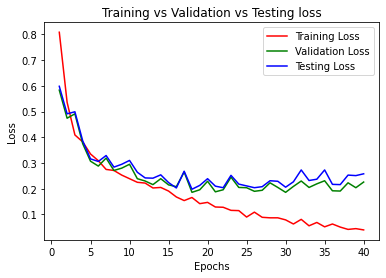

Accuracy on the testing dataset = 93.83
Precision = 0.94
Recall = 0.94
Fscore = 0.94


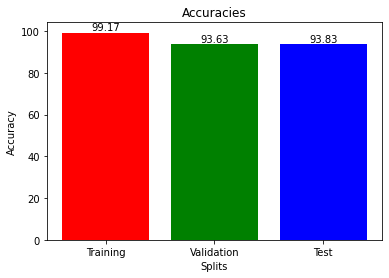

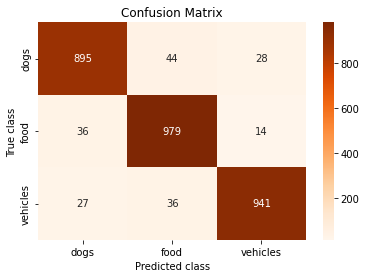

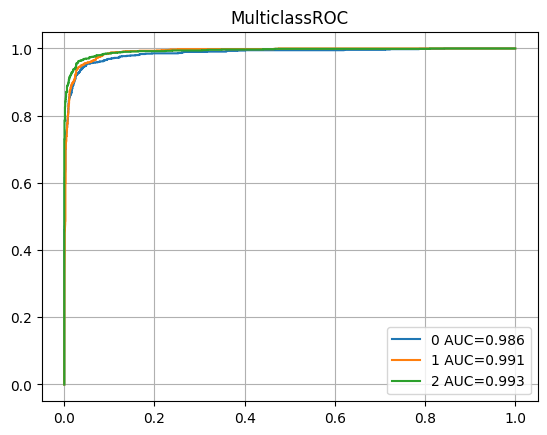

In [13]:
VGG13_M1 = VGG13(dropoutAdd=False).to(device)
# Regularization (L2)
l2_reg = 0.0001
criterion_M1 = nn.CrossEntropyLoss()
optimizer_M1 = optim.Adam(VGG13_M1.parameters(),
                          lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=VGG13_M1, criterion=criterion_M1,
                                                                                     optimizer=optimizer_M1, earlyStopping=False, imageAug=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=VGG13_M1, imageAug=False)

### Model with Regularization and Dropout

[1, 300], Training loss: 0.838, Validation loss: 0.675, Testing loss: 0.691
[1, 600], Training loss: 0.547, Validation loss: 0.473, Testing loss: 0.482
[2, 300], Training loss: 0.425, Validation loss: 0.414, Testing loss: 0.421
[2, 600], Training loss: 0.38, Validation loss: 0.413, Testing loss: 0.426
[3, 300], Training loss: 0.348, Validation loss: 0.329, Testing loss: 0.346
[3, 600], Training loss: 0.323, Validation loss: 0.364, Testing loss: 0.373
[4, 300], Training loss: 0.304, Validation loss: 0.274, Testing loss: 0.291
[4, 600], Training loss: 0.285, Validation loss: 0.283, Testing loss: 0.297
[5, 300], Training loss: 0.26, Validation loss: 0.272, Testing loss: 0.282
[5, 600], Training loss: 0.253, Validation loss: 0.271, Testing loss: 0.284
[6, 300], Training loss: 0.239, Validation loss: 0.255, Testing loss: 0.281
[6, 600], Training loss: 0.242, Validation loss: 0.257, Testing loss: 0.262
[7, 300], Training loss: 0.221, Validation loss: 0.242, Testing loss: 0.259
[7, 600], Trai

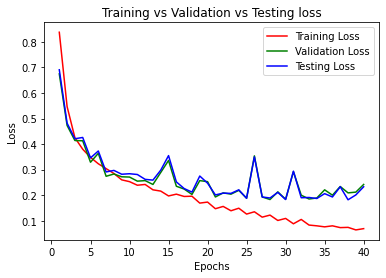

Accuracy on the testing dataset = 94.67
Precision = 0.95
Recall = 0.95
Fscore = 0.95


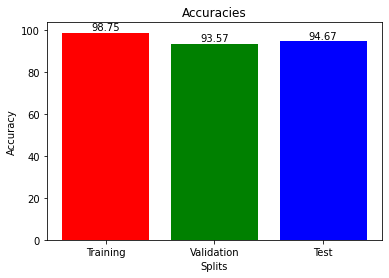

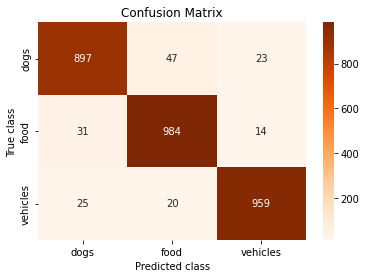

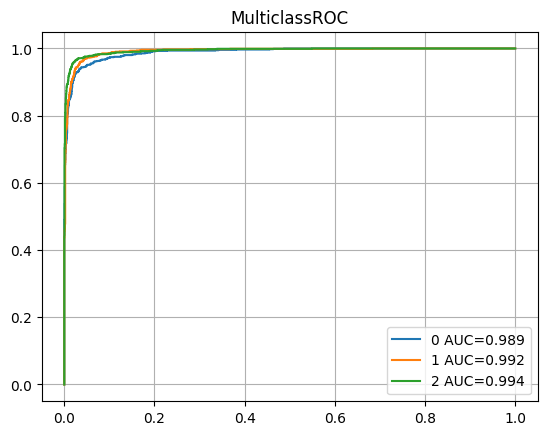

In [14]:
VGG13_M2 = VGG13(dropoutAdd=True).to(device)
# Regularization (L2)
l2_reg = 0.0001
criterion_M2 = nn.CrossEntropyLoss()
optimizer_M2 = optim.Adam(VGG13_M2.parameters(),
                          lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=VGG13_M2, criterion=criterion_M2,
                                                                                     optimizer=optimizer_M2, earlyStopping=False, imageAug=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=VGG13_M2, imageAug=False)

### Model with Regularization, Dropout and Early Stopping

[1, 300], Training loss: 0.864, Validation loss: 0.728, Testing loss: 0.704
[1, 600], Training loss: 0.59, Validation loss: 0.482, Testing loss: 0.501
[2, 300], Training loss: 0.435, Validation loss: 0.466, Testing loss: 0.473
[2, 600], Training loss: 0.393, Validation loss: 0.358, Testing loss: 0.372
[3, 300], Training loss: 0.362, Validation loss: 0.408, Testing loss: 0.425
[3, 600], Training loss: 0.332, Validation loss: 0.378, Testing loss: 0.393
[4, 300], Training loss: 0.314, Validation loss: 0.283, Testing loss: 0.301
[4, 600], Training loss: 0.282, Validation loss: 0.318, Testing loss: 0.332
[5, 300], Training loss: 0.273, Validation loss: 0.26, Testing loss: 0.268
[5, 600], Training loss: 0.254, Validation loss: 0.306, Testing loss: 0.312
[6, 300], Training loss: 0.247, Validation loss: 0.321, Testing loss: 0.314
[6, 600], Training loss: 0.227, Validation loss: 0.266, Testing loss: 0.265
[7, 300], Training loss: 0.221, Validation loss: 0.23, Testing loss: 0.239
[7, 600], Train

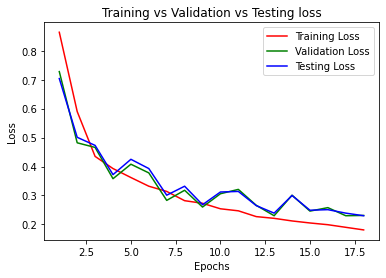

Accuracy on the testing dataset = 92.13
Precision = 0.92
Recall = 0.92
Fscore = 0.92


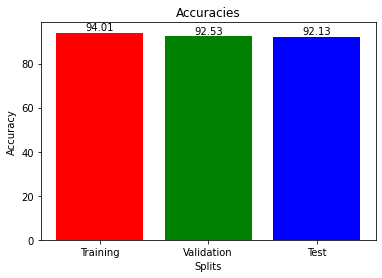

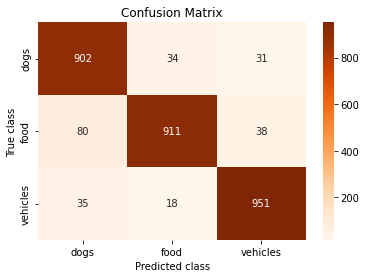

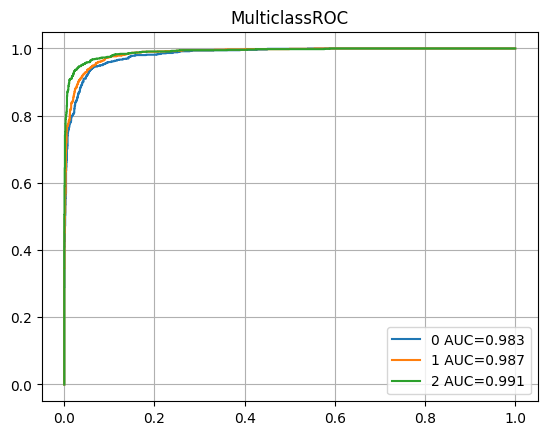

In [15]:
VGG13_M3 = VGG13(dropoutAdd=True).to(device)
# Regularization (L2)
l2_reg = 0.0001
criterion_M3 = nn.CrossEntropyLoss()
optimizer_M3 = optim.Adam(VGG13_M3.parameters(),
                          lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=VGG13_M3, criterion=criterion_M3,
                                                                                     optimizer=optimizer_M3, earlyStopping=True, imageAug=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=VGG13_M3, imageAug=False)

### Model with Regularization, Dropout, Early Stopping and Image Augmentation

[1, 300], Training loss: 0.913, Validation loss: 0.858, Testing loss: 0.865
[1, 600], Training loss: 0.759, Validation loss: 0.765, Testing loss: 0.782
[2, 300], Training loss: 0.645, Validation loss: 0.63, Testing loss: 0.629
[2, 600], Training loss: 0.606, Validation loss: 0.593, Testing loss: 0.589
[3, 300], Training loss: 0.568, Validation loss: 0.535, Testing loss: 0.532
[3, 600], Training loss: 0.561, Validation loss: 0.574, Testing loss: 0.627
[4, 300], Training loss: 0.536, Validation loss: 0.509, Testing loss: 0.517
[4, 600], Training loss: 0.527, Validation loss: 0.546, Testing loss: 0.555
[5, 300], Training loss: 0.517, Validation loss: 0.495, Testing loss: 0.549
[5, 600], Training loss: 0.498, Validation loss: 0.472, Testing loss: 0.486
[6, 300], Training loss: 0.493, Validation loss: 0.486, Testing loss: 0.49
[6, 600], Training loss: 0.469, Validation loss: 0.473, Testing loss: 0.496
[7, 300], Training loss: 0.467, Validation loss: 0.464, Testing loss: 0.51
[7, 600], Train

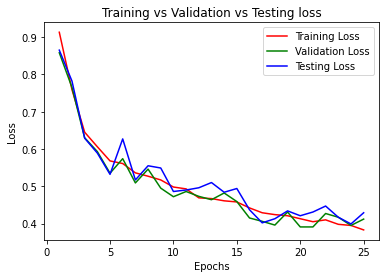

Accuracy on the testing dataset = 82.13
Precision = 0.83
Recall = 0.82
Fscore = 0.82


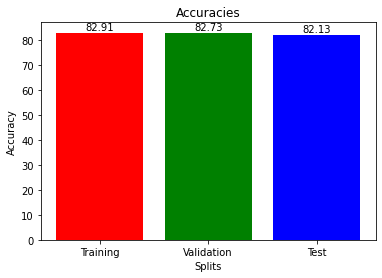

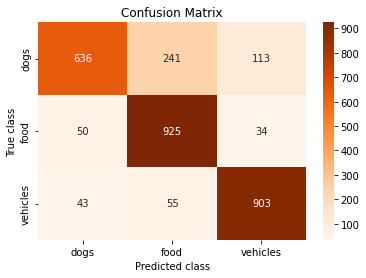

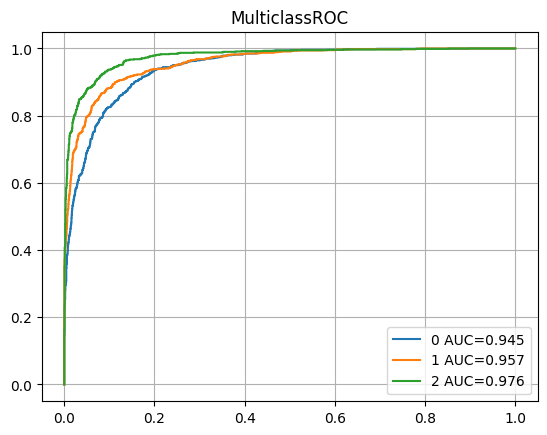

In [19]:
VGG13_M4 = VGG13(dropoutAdd=True).to(device)
# Regularization (L2)
l2_reg = 0.0001
criterion_M4 = nn.CrossEntropyLoss()
optimizer_M4 = optim.Adam(VGG13_M4.parameters(),
                          lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=VGG13_M4, criterion=criterion_M4,
                                                                                     optimizer=optimizer_M4, earlyStopping=True, imageAug=True)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=VGG13_M4, imageAug=True)

### Best model weights

In [21]:
# Save model weights with best accuracy
torch.save(VGG13_M2.state_dict(), 'ngupta22_kchavan_assignment1_part_2.pt')